In [39]:
# pip install numba

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 13.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 6.3 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import zipfile
# import os

# # 定义压缩包路径和目标文件夹路径
# zip_file_path = 'archive.zip'
# extract_folder_path = r'archive'

# # 创建目标文件夹（如果不存在）
# os.makedirs(extract_folder_path, exist_ok=True)

# # 解压缩压缩包
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_folder_path)

# print(f"Successfully extracted to {extract_folder_path}")

In [3]:
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2023-12-24 11:48:49.508575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 11:48:49.669508: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [4]:
data_dir = r'archive/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Columns: 2353 entries, pixel0000 to label
dtypes: int64(2353)
memory usage: 179.8 MB


In [6]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [7]:
data["label"].value_counts()

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64

In [8]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [9]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

In [10]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2: ('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [11]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(35201,)
(11734, 28, 28, 3)
(11734,)


In [13]:
from tensorflow.python.keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

In [15]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense

# Define the depthwise separable CNN model
def depthwise_resnet(input_shape, num_classes):
    model = Sequential()

    # Depthwise separable convolution block 1
    model.add(DepthwiseConv2D(3, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(64, (1, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Depthwise separable convolution block 2
    model.add(DepthwiseConv2D(3, strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(128, (1, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Depthwise separable convolution block 3
    model.add(DepthwiseConv2D(3, strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(256, (1, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Global average pooling and dense layers
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation='softmax'))

    return model




In [17]:
# Set input shape and number of classes
input_shape = (28, 28, 3)  # Example input shape, adjust based on your requirements
num_classes = 7  # Adjust based on your classification task

# Create the depthwise separable CNN model
model = depthwise_resnet(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

2023-12-24 11:48:58.672912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 11:48:59.356163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d (Depthwise  (None, 28, 28, 3)        30        
 Conv2D)                                                         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 3)        12        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 28, 28, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        256       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                        

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
history = model.fit(X_train ,
                    y_train ,
                    epochs=400 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction,EarlyStopping(monitor='loss', patience=10, restore_best_weights = True)])

2023-12-24 11:49:00.164753: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 662342016 exceeds 10% of free system memory.
2023-12-24 11:49:00.681937: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 662342016 exceeds 10% of free system memory.


Epoch 1/400


2023-12-24 11:49:02.814522: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


 19/276 [=>............................] - ETA: 2s - loss: 1.7167 - accuracy: 0.3326

2023-12-24 11:49:03.392689: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


276/276 [==============================] - 6s 14ms/step - loss: 1.2599 - accuracy: 0.5370 - val_loss: 3.0555 - val_accuracy: 0.1468 - lr: 0.0010
Epoch 2/400
276/276 [==============================] - 3s 11ms/step - loss: 0.8027 - accuracy: 0.7227 - val_loss: 1.5780 - val_accuracy: 0.4005 - lr: 0.0010
Epoch 3/400
276/276 [==============================] - 3s 11ms/step - loss: 0.5871 - accuracy: 0.8028 - val_loss: 0.7772 - val_accuracy: 0.7072 - lr: 0.0010
Epoch 4/400
276/276 [==============================] - 3s 11ms/step - loss: 0.4744 - accuracy: 0.8438 - val_loss: 0.6554 - val_accuracy: 0.7517 - lr: 0.0010
Epoch 5/400
276/276 [==============================] - 3s 11ms/step - loss: 0.3990 - accuracy: 0.8690 - val_loss: 0.6877 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 6/400
276/276 [==============================] - 3s 11ms/step - loss: 0.3554 - accuracy: 0.8842 - val_loss: 0.7018 - val_accuracy: 0.7309 - lr: 0.0010
Epoch 7/400
275/276 [============================>.] - ETA: 0s - loss:

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix

def plot_curves(y_true, y_scores):
    # 计算ROC曲线的参数
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # 计算Precision-Recall曲线的参数
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    # 计算其他指标的值
    threshold = 0.5
    y_pred = [1 if score >= threshold else 0 for score in y_scores]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred)

    # 绘制ROC-AUC曲线
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC CURVE')
    plt.legend(loc="lower right")

    # 绘制Recall曲线
    plt.subplot(3, 3, 2)
    plt.plot(recall, label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.title('RECALL CURVE')
    plt.legend(loc="lower right")

    # 绘制Precision曲线
    plt.subplot(3, 3, 3)
    plt.plot(precision, label='Precision')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title('PRECISION CURVE')
    plt.legend(loc="lower right")

    thresholds = np.linspace(0, 1, 100)  # 使用不同的阈值值

    sensitivities = [recall_score(y_true, [1 if score >= t else 0 for score in y_scores]) for t in thresholds]
    specificities = [tn / (tn + fp) for t in thresholds]
    f1_scores = [f1_score(y_true, [1 if score >= t else 0 for score in y_scores]) for t in thresholds]

    # 绘制Sensitivity曲线
    plt.subplot(3, 3, 4)
    plt.plot(thresholds, sensitivities, label='Sensitivity')
    plt.xlabel('Threshold')
    plt.ylabel('Sensitivity')
    plt.title('SENSITIVITY CURVE')
    plt.legend(loc="lower right")

    # 计算Specificity曲线的参数
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    tnr = 1 - fpr  # True Negative Rate
    plt.subplot(3, 3, 5)
    plt.plot(tnr, tpr, color='green', lw=2, label='Specificity curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('True Negative Rate (Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Specificity Curve')
    plt.legend(loc='lower right')


    # 绘制F1 Score曲线
    plt.subplot(3, 3, 6)
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 SCORE CURVE')
    plt.legend(loc="lower right")

    # 绘制Precision-Recall曲线
    plt.subplot(3, 3, 7)
    plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PRECISION-RECALL CURVE')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


In [20]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    # Get training and testing accuracy and loss histories
    training_accuracy = history.history['accuracy']
    testing_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    testing_loss = history.history['val_loss']

    # Plot training and testing accuracy curves
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(testing_accuracy, label='Testing Accuracy')
    plt.title('Training vs Testing Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training and testing loss curves
    plt.subplot(1, 2, 2)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(testing_loss, label='Testing Loss')
    plt.title('Training vs Testing Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()



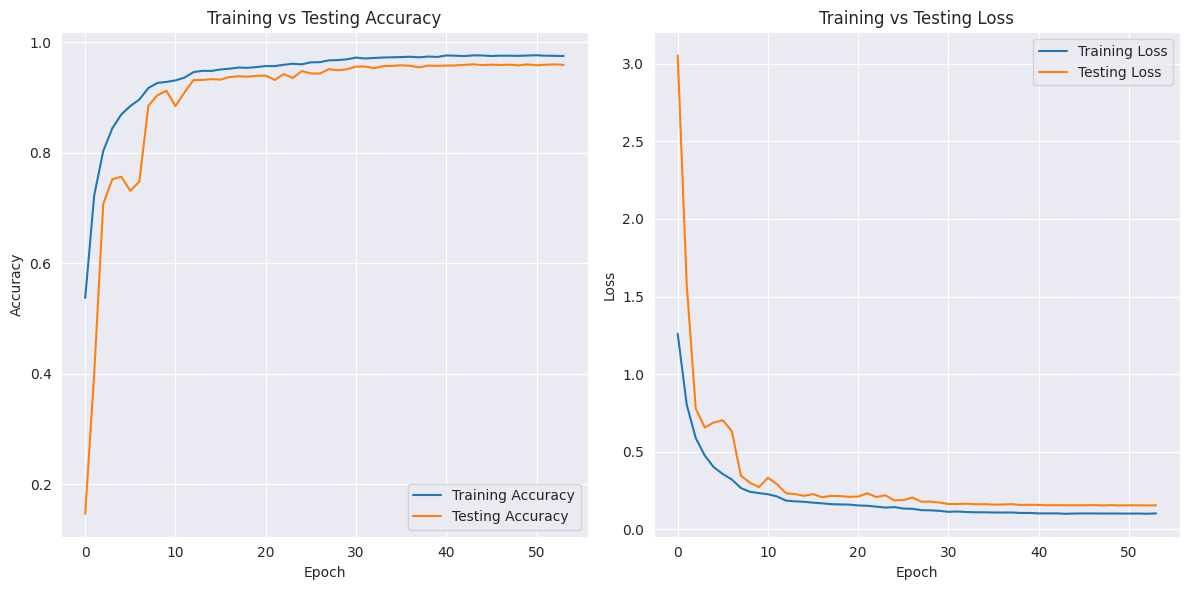

In [21]:
plot_accuracy_and_loss(history)

In [22]:
# import tensorflow as tf
# model.save_weights('weights\DCNN.h5')

In [23]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

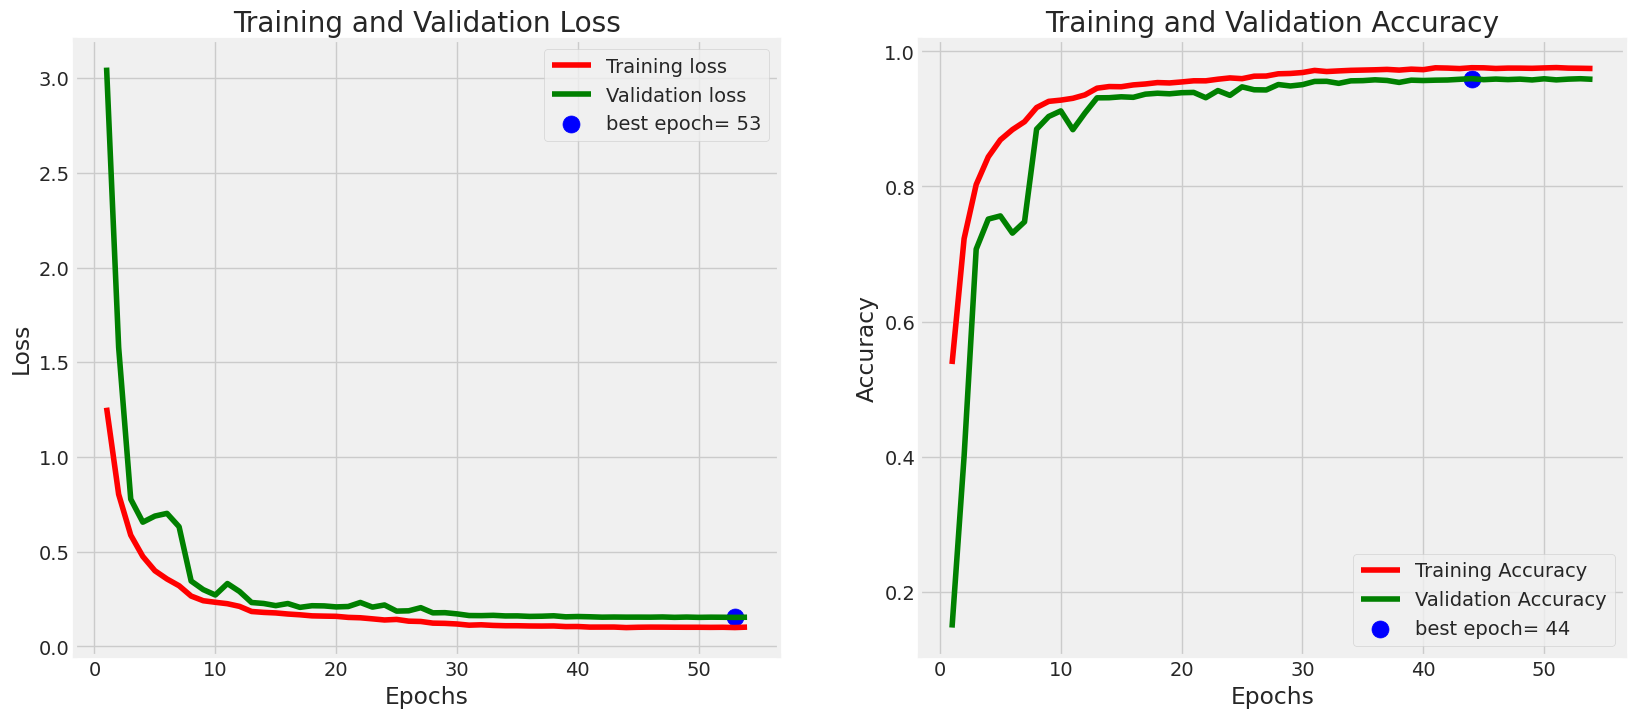

In [24]:
plot_training(history)

In [25]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2023-12-24 11:51:50.810141: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 662342016 exceeds 10% of free system memory.
2023-12-24 11:51:51.336452: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 662342016 exceeds 10% of free system memory.


367/367 [==============================] - 2s 4ms/step - loss: 0.1541 - accuracy: 0.9597
Train Loss:  0.08568207174539566
Train Accuracy:  0.9795176386833191
--------------------
Test Loss:  0.15407128632068634
Test Accuracy:  0.9596897959709167


In [26]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 [==============================] - 1s 3ms/step


367/367 [==============================] - 1s 3ms/step


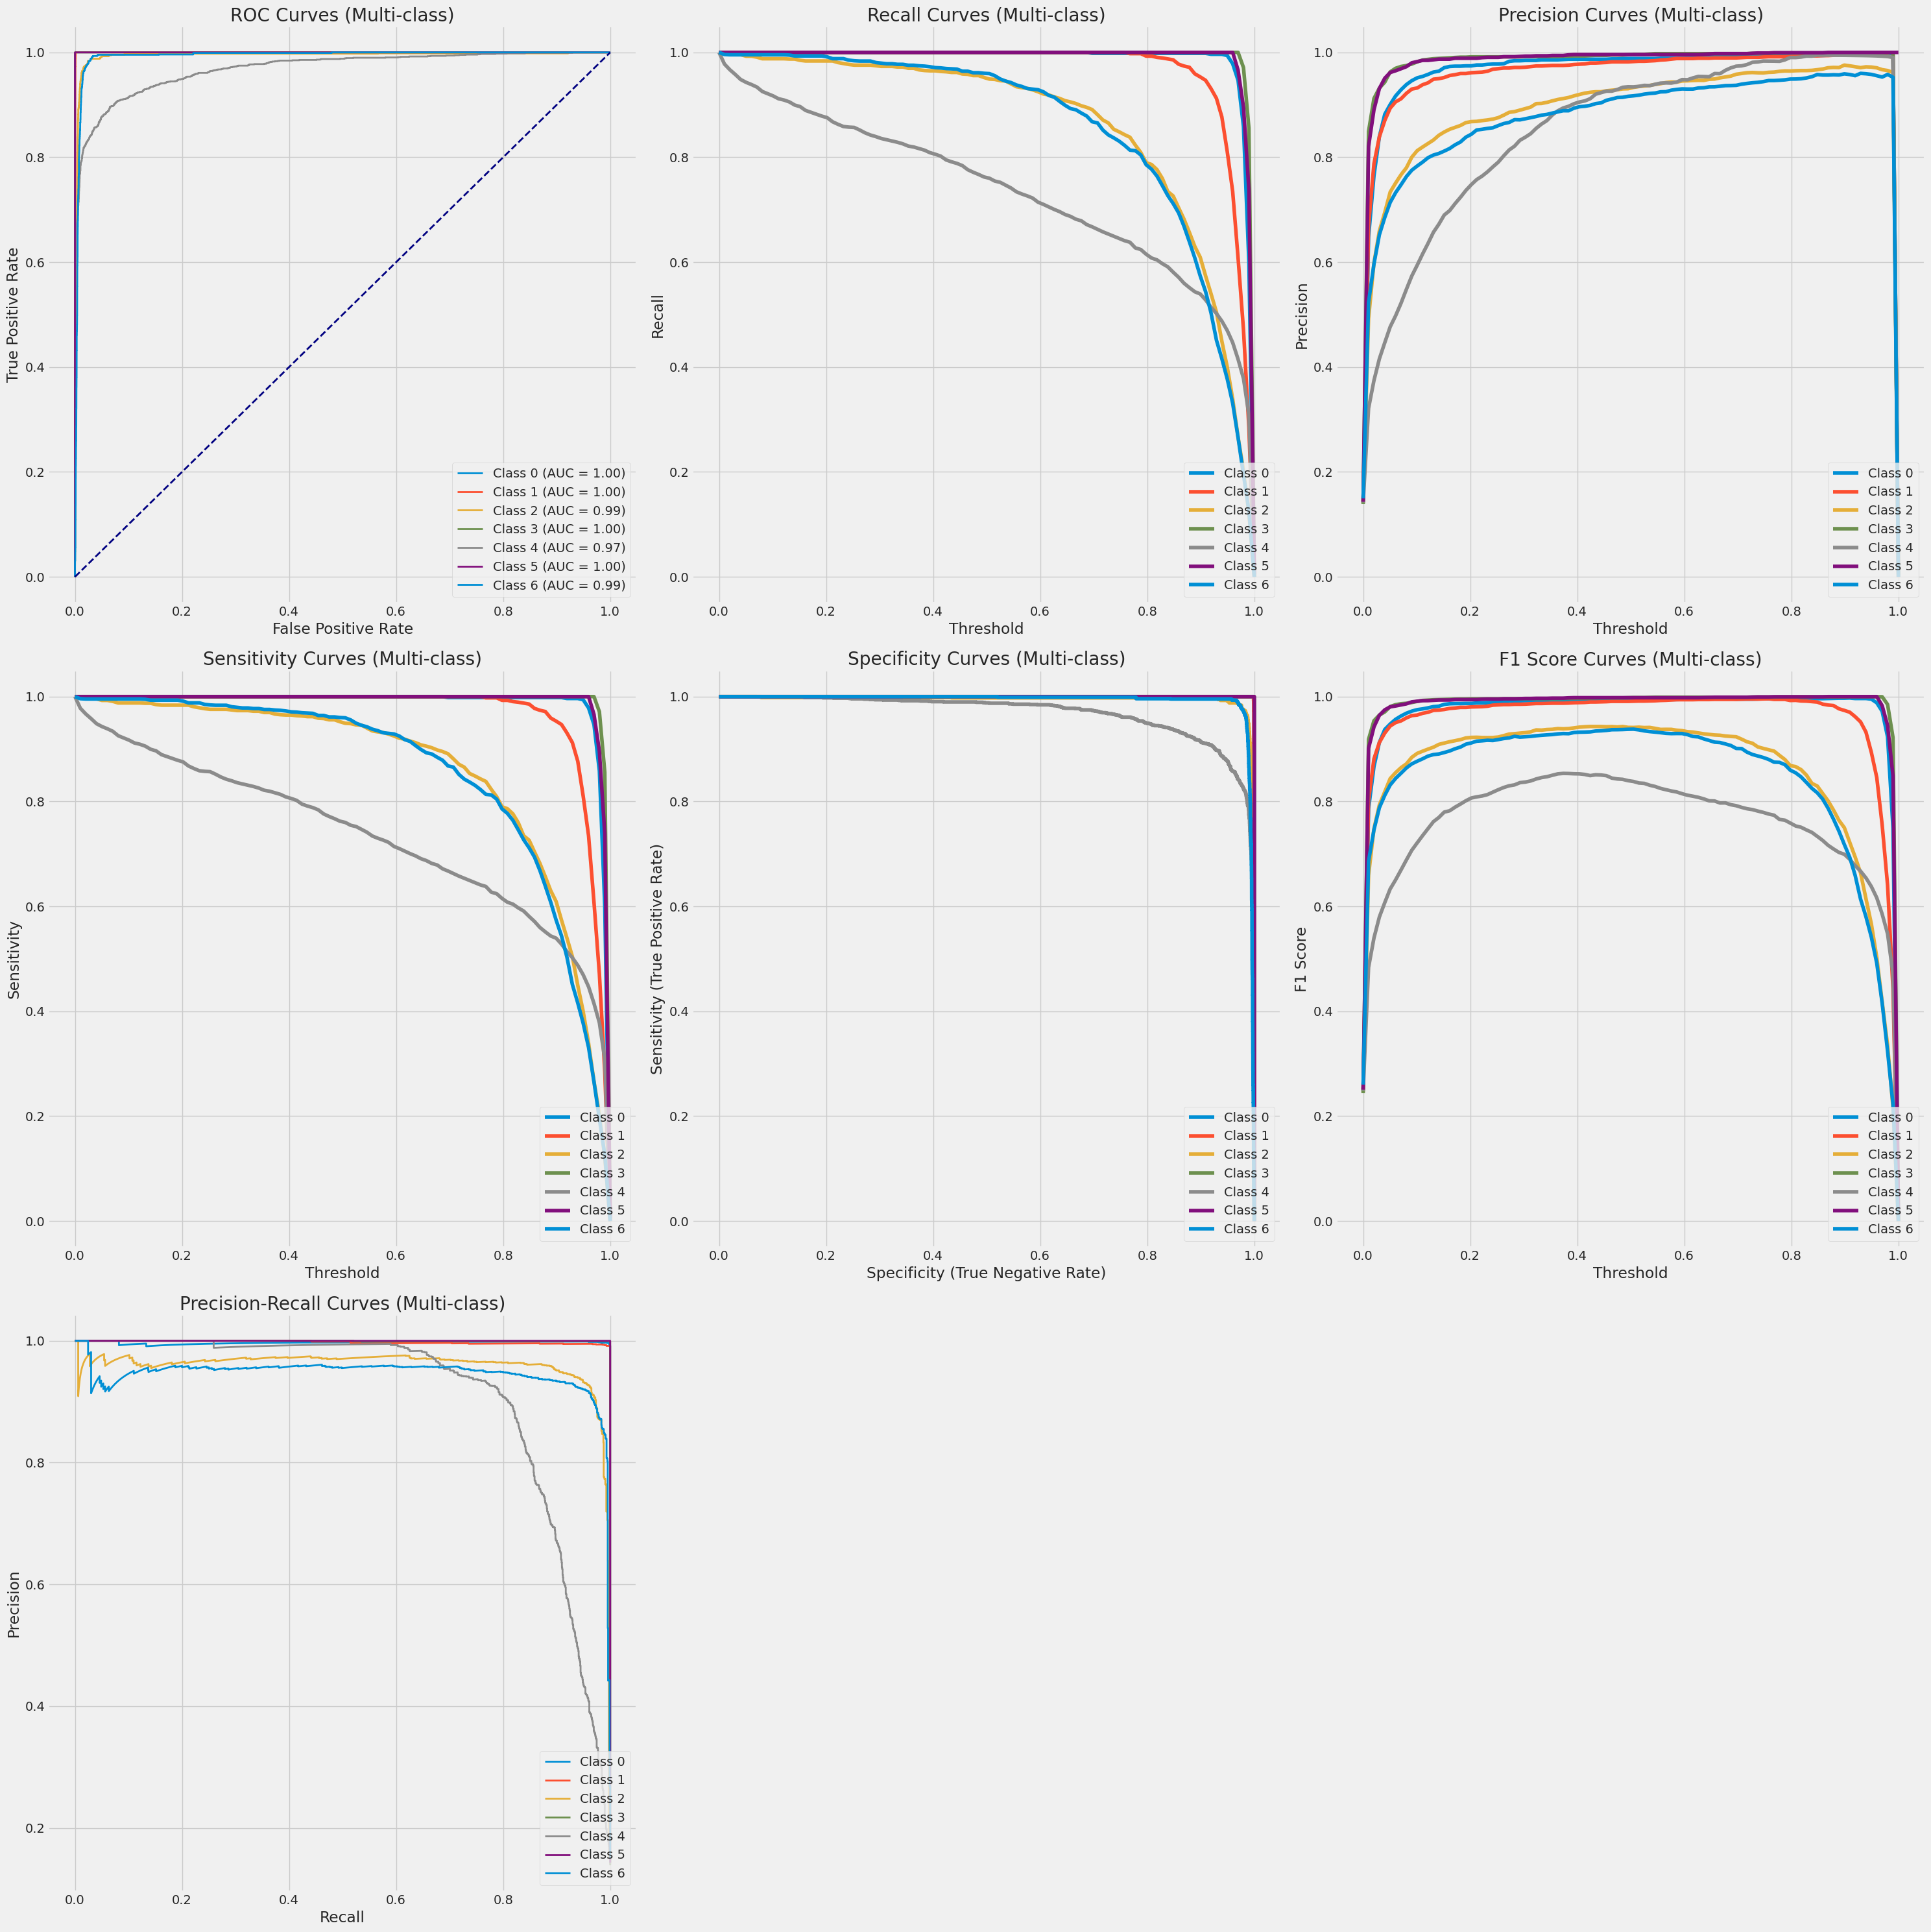

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

def plot_curves(y_true, y_scores):
    num_classes = y_scores.shape[1]
    
    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    
    # Initialize figure
    plt.figure(figsize=(30, 30))
    
    # Plot ROC curve for each class
    plt.subplot(3, 3, 1)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Multi-class)')
    plt.legend(loc="lower right")
    
    # Plot Recall curve for each class
    plt.subplot(3, 3, 2)
    for i in range(num_classes):
        recall_values = [recall_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        plt.plot(np.linspace(0, 1, 100), recall_values, label=f'Class {i}')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.title('Recall Curves (Multi-class)')
    plt.legend(loc="lower right")

    # Plot Precision curve for each class
    plt.subplot(3, 3, 3)
    for i in range(num_classes):
        precision_values = [precision_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        plt.plot(np.linspace(0, 1, 100), precision_values, label=f'Class {i}')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title('Precision Curves (Multi-class)')
    plt.legend(loc="lower right")

    # Plot Sensitivity curve for each class
    plt.subplot(3, 3, 4)
    for i in range(num_classes):
        sensitivity_values = [recall_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        plt.plot(np.linspace(0, 1, 100), sensitivity_values, label=f'Class {i}')
    plt.xlabel('Threshold')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity Curves (Multi-class)')
    plt.legend(loc="lower right")

    # Plot Specificity curve for each class
    plt.subplot(3, 3, 5)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        tnr = 1 - fpr
        plt.plot(tnr, tpr, label=f'Class {i}')
    plt.xlabel('Specificity (True Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('Specificity Curves (Multi-class)')
    plt.legend(loc='lower right')

    # Plot F1 Score curve for each class
    plt.subplot(3, 3, 6)
    for i in range(num_classes):
        f1_values = [f1_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        plt.plot(np.linspace(0, 1, 100), f1_values, label=f'Class {i}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Curves (Multi-class)')
    plt.legend(loc="lower right")

    # Plot Precision-Recall curve for each class
    plt.subplot(3, 3, 7)
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        plt.plot(recall, precision, lw=2, label=f'Class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves (Multi-class)')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

y_pred_probs = model.predict(X_test)
# Assuming y_pred_probs contains probabilities for each class
plot_curves(y_true, y_pred_probs)


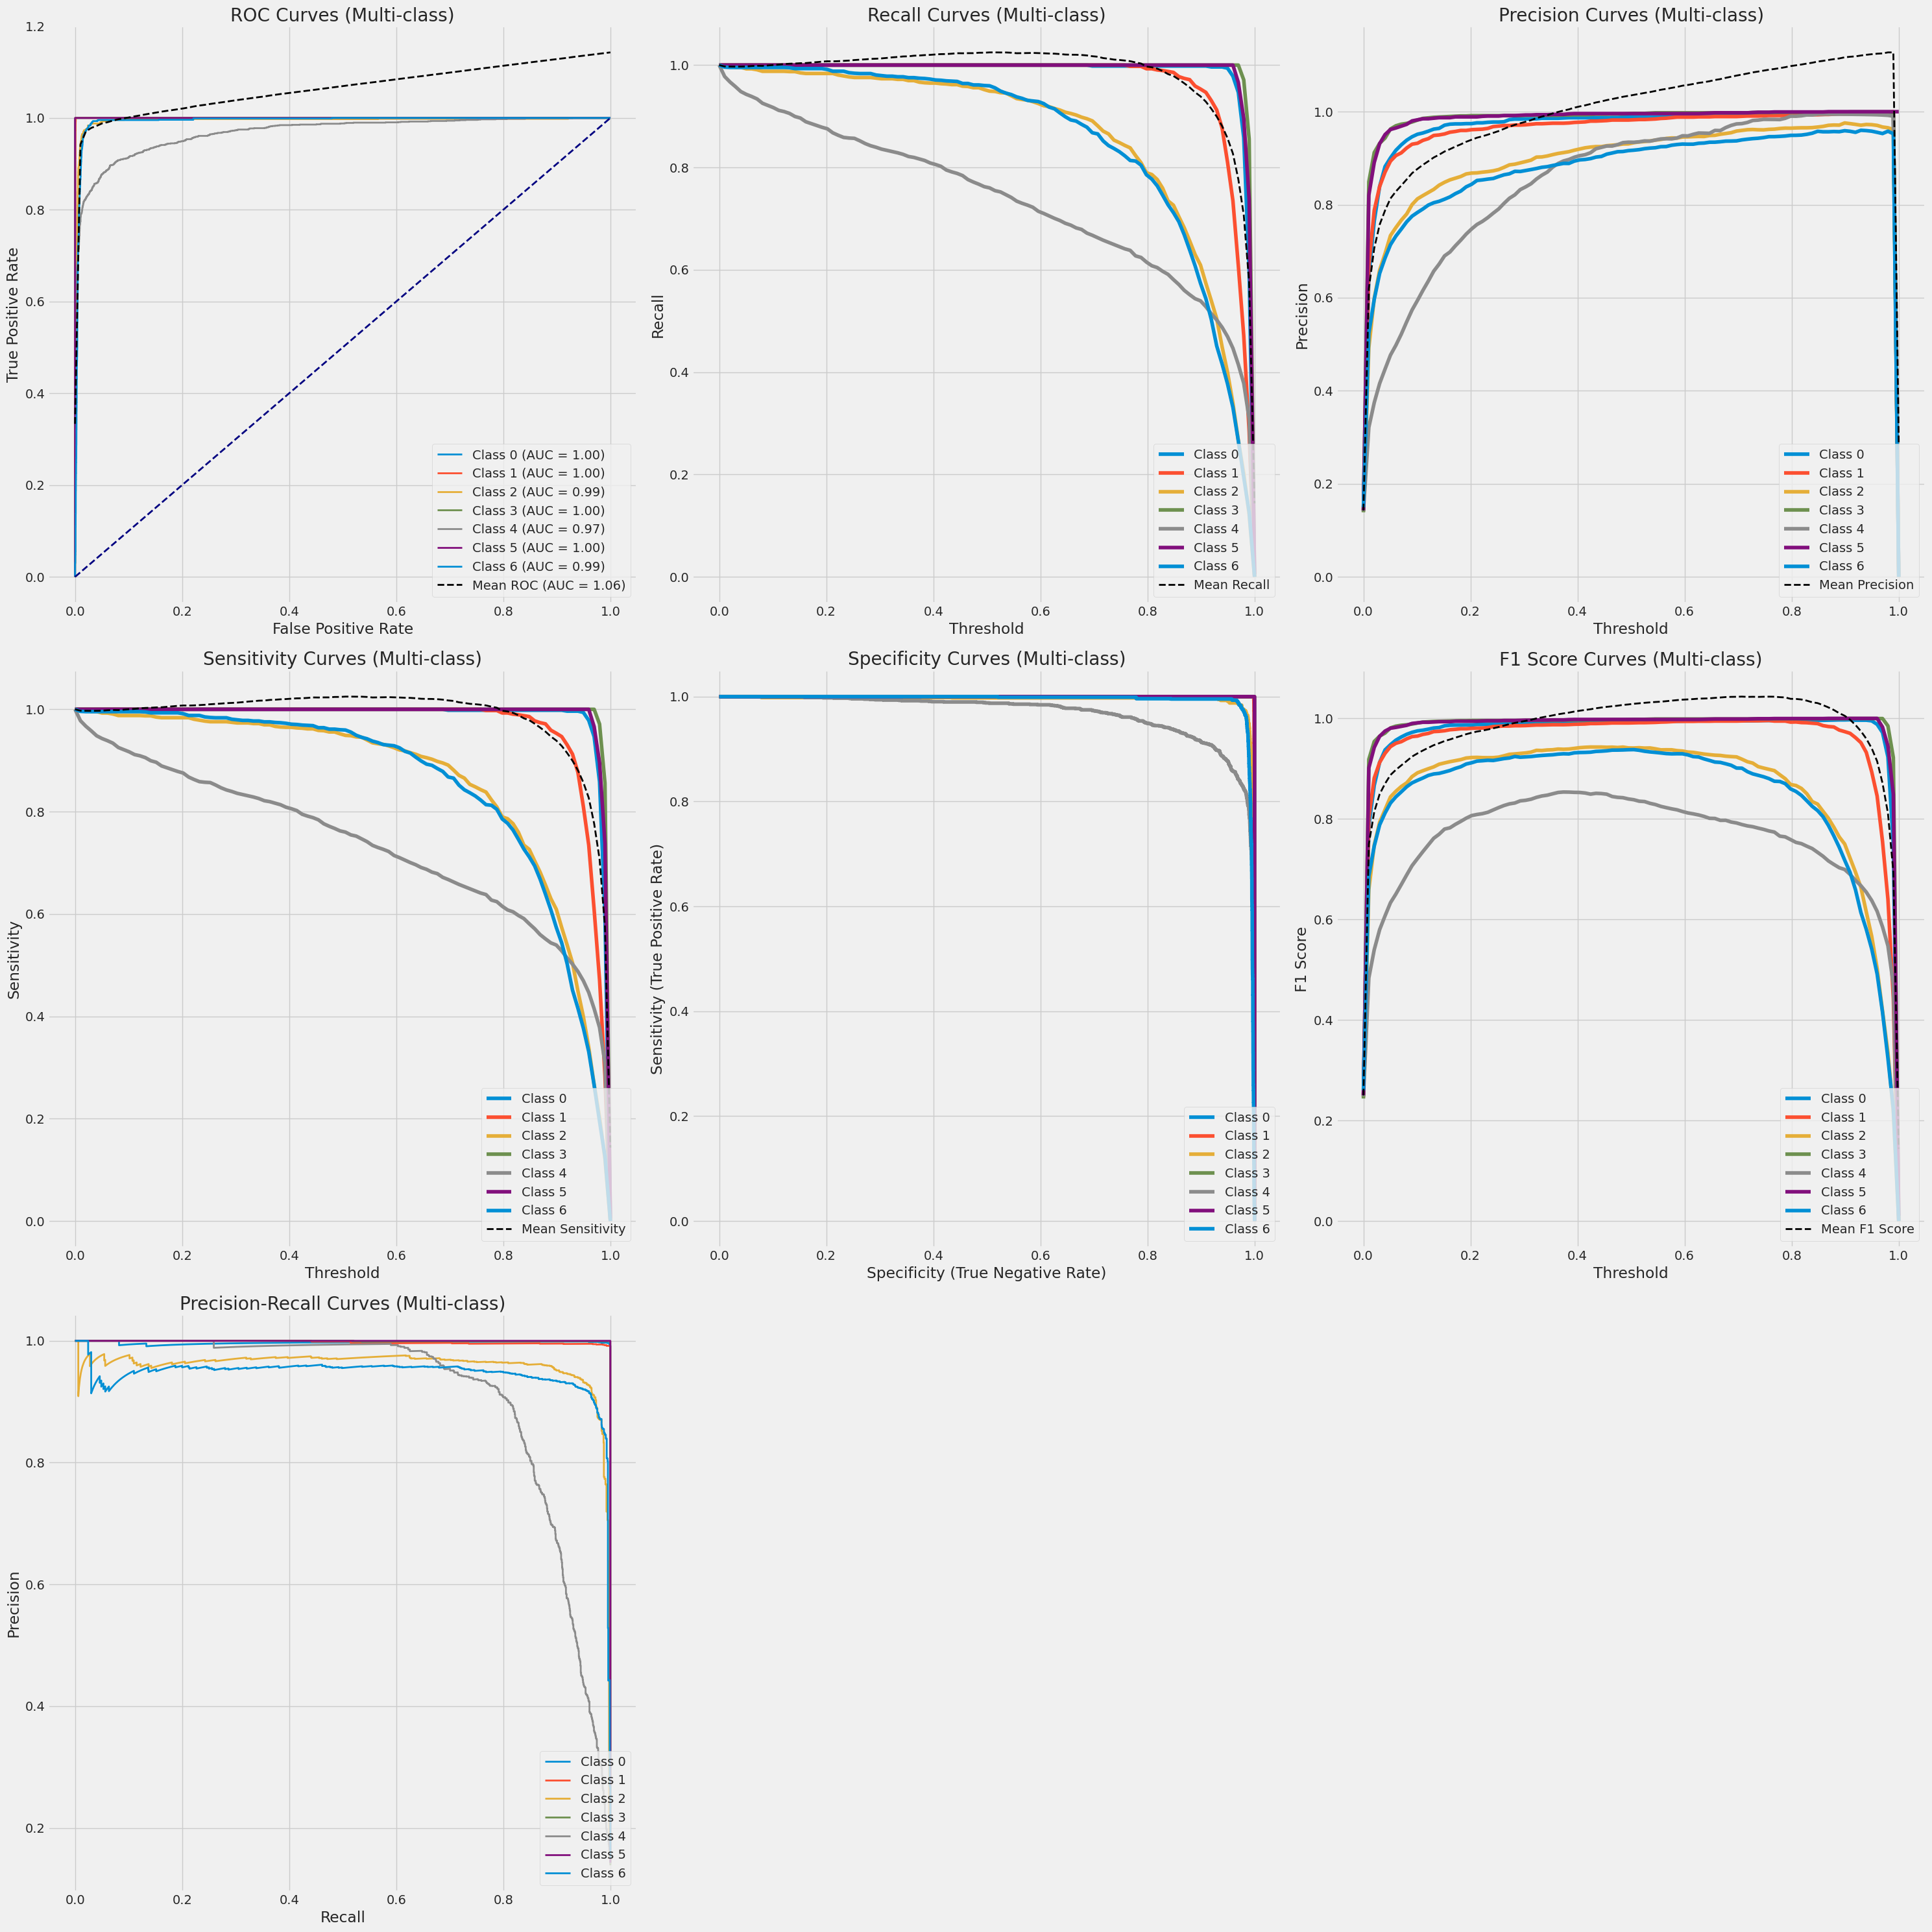

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

def plot_curves2(y_true, y_scores):
    num_classes = y_scores.shape[1]
    
    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    
    # Initialize figure
    plt.figure(figsize=(30, 30))
    
    # Lists to store mean values
    mean_fpr, mean_tpr = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
    mean_recall, mean_precision = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
    mean_sensitivity, mean_f1 = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
    
    # Plot ROC curve for each class
    plt.subplot(3, 3, 1)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= num_classes
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', lw=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Multi-class)')
    plt.legend(loc="lower right")
    
    # Plot Recall curve for each class
    plt.subplot(3, 3, 2)
    for i in range(num_classes):
        recall_values = [recall_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        plt.plot(np.linspace(0, 1, 100), recall_values, label=f'Class {i}')
        mean_recall += np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, 100), recall_values)
    mean_recall /= num_classes
    plt.plot(np.linspace(0, 1, 100), mean_recall, color='black', linestyle='--', lw=2, label='Mean Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.title('Recall Curves (Multi-class)')
    plt.legend(loc="lower right")

    # Plot Precision curve for each class
    plt.subplot(3, 3, 3)
    for i in range(num_classes):
        precision_values = [precision_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        plt.plot(np.linspace(0, 1, 100), precision_values, label=f'Class {i}')
        mean_precision += np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, 100), precision_values)
    mean_precision /= num_classes
    plt.plot(np.linspace(0, 1, 100), mean_precision, color='black', linestyle='--', lw=2, label='Mean Precision')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title('Precision Curves (Multi-class)')
    plt.legend(loc="lower right")

    # Plot Sensitivity curve for each class
    plt.subplot(3, 3, 4)
    for i in range(num_classes):
        sensitivity_values = [recall_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        plt.plot(np.linspace(0, 1, 100), sensitivity_values, label=f'Class {i}')
        mean_sensitivity += np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, 100), sensitivity_values)
    mean_sensitivity /= num_classes
    plt.plot(np.linspace(0, 1, 100), mean_sensitivity, color='black', linestyle='--', lw=2, label='Mean Sensitivity')
    plt.xlabel('Threshold')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity Curves (Multi-class)')
    plt.legend(loc="lower right")

    # Plot Specificity curve for each class
    plt.subplot(3, 3, 5)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        tnr = 1 - fpr
        plt.plot(tnr, tpr, label=f'Class {i}')
    plt.xlabel('Specificity (True Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('Specificity Curves (Multi-class)')
    plt.legend(loc='lower right')

    # Plot F1 Score curve for each class
    plt.subplot(3, 3, 6)
    for i in range(num_classes):
        f1_values = [f1_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        plt.plot(np.linspace(0, 1, 100), f1_values, label=f'Class {i}')
        mean_f1 += np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, 100), f1_values)
    mean_f1 /= num_classes
    plt.plot(np.linspace(0, 1, 100), mean_f1, color='black', linestyle='--', lw=2, label='Mean F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Curves (Multi-class)')
    plt.legend(loc="lower right")

    # Plot Precision-Recall curve for each class
    plt.subplot(3, 3, 7)
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        plt.plot(recall, precision, lw=2, label=f'Class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves (Multi-class)')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Assuming y_pred

plot_curves2(y_true, y_pred_probs)

In [29]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


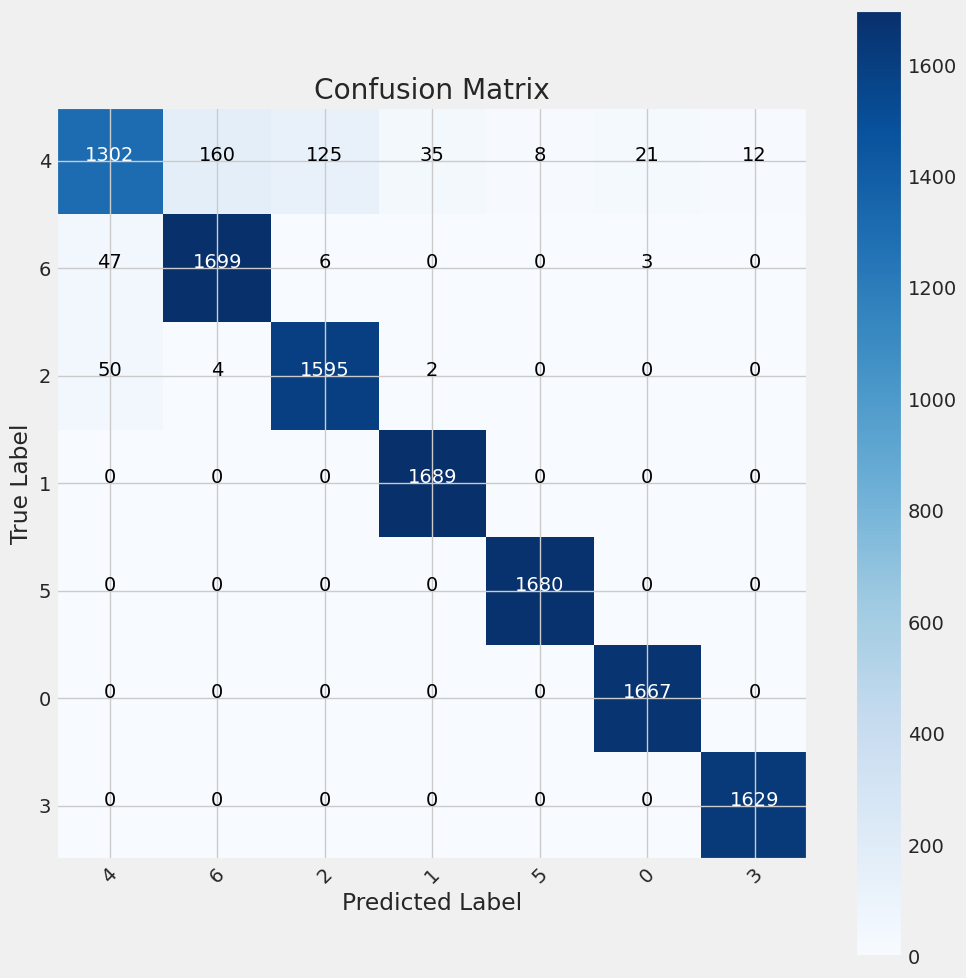

In [30]:
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [31]:
#model.save('Skin Cancer.h5')

In [37]:
# from keras import backend as K
# import gc

# del model

# K.clear_session()
# gc.collect()

41927

In [40]:
# #You need to install numba using 'pip install numba'

# from numba import cuda

# cuda.select_device(0)
# cuda.close()

In [36]:
# import tensorflow as tf
# model.save_weights('model_weights/DCNN.h5')